In [5]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision import transforms, datasets, models
from transformers import ViTForImageClassification, ViTImageProcessor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torch.optim import AdamW
from torch.amp import autocast, GradScaler
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize


import timm  # For PreTrained models
import json



In [6]:
# Define transformations with data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

In [10]:
data_dir = "/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES"

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

class_name_mapping = {
    "1. Eczema 1677": "Eczema",
    "2. Melanoma 15.75k": "Melanoma",
    "3. Atopic Dermatitis - 1.25k": "Atopic Dermatitis",
    "4. Basal Cell Carcinoma (BCC) 3323": "Basal Cell Carcinoma (BCC)",
    "5. Melanocytic Nevi (NV) - 7970": "Melanocytic Nevi (NV)",
    "6. Benign Keratosis-like Lesions (BKL) 2624": "Benign Keratosis-like Lesions (BKL)",
    "7. Psoriasis pictures Lichen Planus and related diseases - 2k": "Psoriasis & Lichen Planus",
    "8. Seborrheic Keratoses and other Benign Tumors - 1.8k": "Seborrheic Keratoses",
    "9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k": "Tinea & Fungal Infections",
    "10. Warts Molluscum and other Viral Infections - 2103": "Warts & Molluscum"
}

# Apply class mapping
dataset.class_to_idx = {class_name_mapping[key]: value for key, value in dataset.class_to_idx.items()}
dataset.classes = list(class_name_mapping.values())

# Number of classes
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")



Number of classes: 10


In [11]:
class_counts = Counter([dataset.targets[idx] for idx in range(len(dataset))])
print("\nDataset Class Distribution BEFORE Split:")
for class_idx, count in class_counts.items():
    print(f"Class: {dataset.classes[class_idx]}, Count: {count}")



Dataset Class Distribution BEFORE Split:
Class: Eczema, Count: 1677
Class: Melanoma, Count: 2103
Class: Atopic Dermatitis, Count: 3140
Class: Basal Cell Carcinoma (BCC), Count: 1257
Class: Melanocytic Nevi (NV), Count: 3323
Class: Benign Keratosis-like Lesions (BKL), Count: 7970
Class: Psoriasis & Lichen Planus, Count: 2079
Class: Seborrheic Keratoses, Count: 2055
Class: Tinea & Fungal Infections, Count: 1847
Class: Warts & Molluscum, Count: 1702


In [12]:
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1

train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size  # Ensure total sum matches

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [13]:
print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")



Train: 21722, Validation: 2715, Test: 2716


In [14]:
train_class_counts = Counter([dataset.targets[idx] for idx in train_dataset.indices])

print("\nTrain Dataset Class Distribution BEFORE Undersampling:")
for class_idx, count in train_class_counts.items():
    print(f"Class: {dataset.classes[class_idx]}, Count: {count}")



Train Dataset Class Distribution BEFORE Undersampling:
Class: Benign Keratosis-like Lesions (BKL), Count: 6351
Class: Basal Cell Carcinoma (BCC), Count: 1029
Class: Psoriasis & Lichen Planus, Count: 1706
Class: Tinea & Fungal Infections, Count: 1469
Class: Atopic Dermatitis, Count: 2494
Class: Seborrheic Keratoses, Count: 1621
Class: Warts & Molluscum, Count: 1383
Class: Melanocytic Nevi (NV), Count: 2658
Class: Melanoma, Count: 1692
Class: Eczema, Count: 1319


In [15]:
avg_count = int(np.mean(list(train_class_counts.values())))
print(f"\nUndersampling Majority Classes to {avg_count} Images Each")



Undersampling Majority Classes to 2172 Images Each


In [16]:
# Create balanced train dataset
new_train_indices = []
for class_idx, count in train_class_counts.items():
    class_indices = [idx for idx in train_dataset.indices if dataset.targets[idx] == class_idx]

    if count > avg_count:
        class_indices = class_indices[:avg_count]

    new_train_indices.extend(class_indices)

# New balanced train dataset
balanced_train_dataset = Subset(dataset, new_train_indices)


In [17]:
new_train_class_counts = Counter([dataset.targets[i] for i in new_train_indices])
print("\nTrain dataset class distribution AFTER undersampling:")
for class_idx, count in new_train_class_counts.items():
    print(f"Class: {dataset.classes[class_idx]}, Count: {count}")



Train dataset class distribution AFTER undersampling:
Class: Benign Keratosis-like Lesions (BKL), Count: 2172
Class: Basal Cell Carcinoma (BCC), Count: 1029
Class: Psoriasis & Lichen Planus, Count: 1706
Class: Tinea & Fungal Infections, Count: 1469
Class: Atopic Dermatitis, Count: 2172
Class: Seborrheic Keratoses, Count: 1621
Class: Warts & Molluscum, Count: 1383
Class: Melanocytic Nevi (NV), Count: 2172
Class: Melanoma, Count: 1692
Class: Eczema, Count: 1319


In [18]:
batch_size = 64

train_loader = DataLoader(balanced_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)



In [24]:
class_names = [class_name_mapping[k] for k in sorted(class_name_mapping.keys())]

with open("class_names.json", "w") as f:
    json.dump(class_names, f)

print("Class names saved successfully:", class_names)


Class names saved successfully: ['Eczema', 'Warts & Molluscum', 'Melanoma', 'Atopic Dermatitis', 'Basal Cell Carcinoma (BCC)', 'Melanocytic Nevi (NV)', 'Benign Keratosis-like Lesions (BKL)', 'Psoriasis & Lichen Planus', 'Seborrheic Keratoses', 'Tinea & Fungal Infections']


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('vit_base_patch16_224', pretrained=True)


In [14]:
num_ftrs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, len(dataset.classes)) 
)


model = model.to(device)

In [15]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Define learning rate scheduler with warmup and cosine decay
warmup_epochs = 5
total_epochs = 25
scheduler_warmup = LinearLR(optimizer, start_factor=0.01, total_iters=warmup_epochs)
scheduler_cosine = CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)
scheduler = SequentialLR(optimizer, [scheduler_warmup, scheduler_cosine], milestones=[warmup_epochs])


patience = 3
best_val_loss = float('inf')
best_val_acc = 0.0
best_epoch = 0
early_stop_counter = 0

In [17]:
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)


In [18]:
from tqdm import tqdm  
epochs = 25

# Training loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(total_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Compute additional metrics
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Epoch {epoch+1}/{total_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f} ")

    # Check for early stopping and save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_epoch = epoch
        early_stop_counter = 0

        # Save the best model
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
        }, os.path.join(save_dir, 'best_model.pth'))
        print(f"New best model saved at epoch {epoch+1} with val loss: {val_loss:.4f} and val acc: {val_acc:.2f}%")
    else:
        early_stop_counter += 1
        print(f"No improvement in val accuracy for {early_stop_counter} epochs")

    # Adjust learning rate
    scheduler.step()

    # Early stopping
    if early_stop_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}!")
        break

print(f"Training finished. Best model saved at epoch {best_epoch+1} with val loss: {best_val_loss:.4f} and val acc: {best_val_acc:.2f}%")

Epoch 1/25: 100%|██████████| 263/263 [05:12<00:00,  1.19s/it]


🔹 Epoch 1/25 | Train Loss: 1.9705 | Train Acc: 33.03% | Val Loss: 1.4108 | Val Acc: 59.96% | Val F1: 0.5857 
New best model saved at epoch 1 with val loss: 1.4108 and val acc: 59.96%


Epoch 2/25: 100%|██████████| 263/263 [05:12<00:00,  1.19s/it]


🔹 Epoch 2/25 | Train Loss: 1.1810 | Train Acc: 68.57% | Val Loss: 0.9666 | Val Acc: 78.45% | Val F1: 0.7808 
New best model saved at epoch 2 with val loss: 0.9666 and val acc: 78.45%


Epoch 3/25: 100%|██████████| 263/263 [05:12<00:00,  1.19s/it]


🔹 Epoch 3/25 | Train Loss: 1.0026 | Train Acc: 77.43% | Val Loss: 0.9072 | Val Acc: 81.33% | Val F1: 0.8165 
New best model saved at epoch 3 with val loss: 0.9072 and val acc: 81.33%


Epoch 4/25: 100%|██████████| 263/263 [05:12<00:00,  1.19s/it]


🔹 Epoch 4/25 | Train Loss: 0.9062 | Train Acc: 82.44% | Val Loss: 0.8722 | Val Acc: 83.50% | Val F1: 0.8340 
New best model saved at epoch 4 with val loss: 0.8722 and val acc: 83.50%


Epoch 5/25: 100%|██████████| 263/263 [05:12<00:00,  1.19s/it]


🔹 Epoch 5/25 | Train Loss: 0.8443 | Train Acc: 85.47% | Val Loss: 0.9046 | Val Acc: 82.39% | Val F1: 0.8275 
No improvement in val accuracy for 1 epochs


Epoch 6/25: 100%|██████████| 263/263 [05:12<00:00,  1.19s/it]


🔹 Epoch 6/25 | Train Loss: 0.8078 | Train Acc: 86.90% | Val Loss: 0.8433 | Val Acc: 84.83% | Val F1: 0.8485 
New best model saved at epoch 6 with val loss: 0.8433 and val acc: 84.83%


Epoch 7/25: 100%|██████████| 263/263 [05:12<00:00,  1.19s/it]


🔹 Epoch 7/25 | Train Loss: 0.7401 | Train Acc: 89.96% | Val Loss: 0.8521 | Val Acc: 85.52% | Val F1: 0.8561 
New best model saved at epoch 7 with val loss: 0.8521 and val acc: 85.52%


Epoch 8/25: 100%|██████████| 263/263 [05:12<00:00,  1.19s/it]


🔹 Epoch 8/25 | Train Loss: 0.6965 | Train Acc: 92.13% | Val Loss: 0.8458 | Val Acc: 85.78% | Val F1: 0.8572 
New best model saved at epoch 8 with val loss: 0.8458 and val acc: 85.78%


Epoch 9/25: 100%|██████████| 263/263 [05:12<00:00,  1.19s/it]


🔹 Epoch 9/25 | Train Loss: 0.6578 | Train Acc: 93.70% | Val Loss: 0.8222 | Val Acc: 86.85% | Val F1: 0.8693 
New best model saved at epoch 9 with val loss: 0.8222 and val acc: 86.85%


Epoch 10/25: 100%|██████████| 263/263 [05:13<00:00,  1.19s/it]


🔹 Epoch 10/25 | Train Loss: 0.6312 | Train Acc: 94.88% | Val Loss: 0.8434 | Val Acc: 85.78% | Val F1: 0.8578 
No improvement in val accuracy for 1 epochs


Epoch 11/25: 100%|██████████| 263/263 [05:13<00:00,  1.19s/it]


🔹 Epoch 11/25 | Train Loss: 0.6098 | Train Acc: 95.83% | Val Loss: 0.8573 | Val Acc: 86.34% | Val F1: 0.8650 
No improvement in val accuracy for 2 epochs


Epoch 12/25: 100%|██████████| 263/263 [05:12<00:00,  1.19s/it]


🔹 Epoch 12/25 | Train Loss: 0.5893 | Train Acc: 96.62% | Val Loss: 0.8704 | Val Acc: 85.82% | Val F1: 0.8600 
No improvement in val accuracy for 3 epochs
Early stopping triggered at epoch 12!
Training finished. Best model saved at epoch 9 with val loss: 0.8222 and val acc: 86.85%


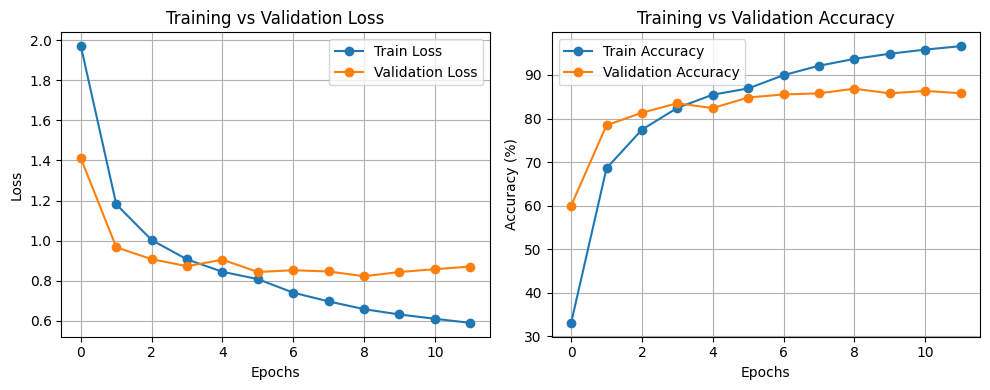

In [19]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", marker="o")
plt.plot(val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Final Test Accuracy: 86.38%

Classification Report:
                                     precision    recall  f1-score   support

                             Eczema     0.7891    0.7389    0.7632       157
                           Melanoma     0.8152    0.7926    0.8037       217
                  Atopic Dermatitis     0.9478    0.9879    0.9675       331
         Basal Cell Carcinoma (BCC)     0.6333    0.7103    0.6696       107
              Melanocytic Nevi (NV)     0.9288    0.9152    0.9219       342
Benign Keratosis-like Lesions (BKL)     0.9823    0.9120    0.9458       852
          Psoriasis & Lichen Planus     0.6872    0.8698    0.7678       192
               Seborrheic Keratoses     0.6973    0.6862    0.6917       188
          Tinea & Fungal Infections     0.8079    0.8563    0.8314       167
                  Warts & Molluscum     0.7875    0.7730    0.7802       163

                           accuracy                         0.8638      2716
                      

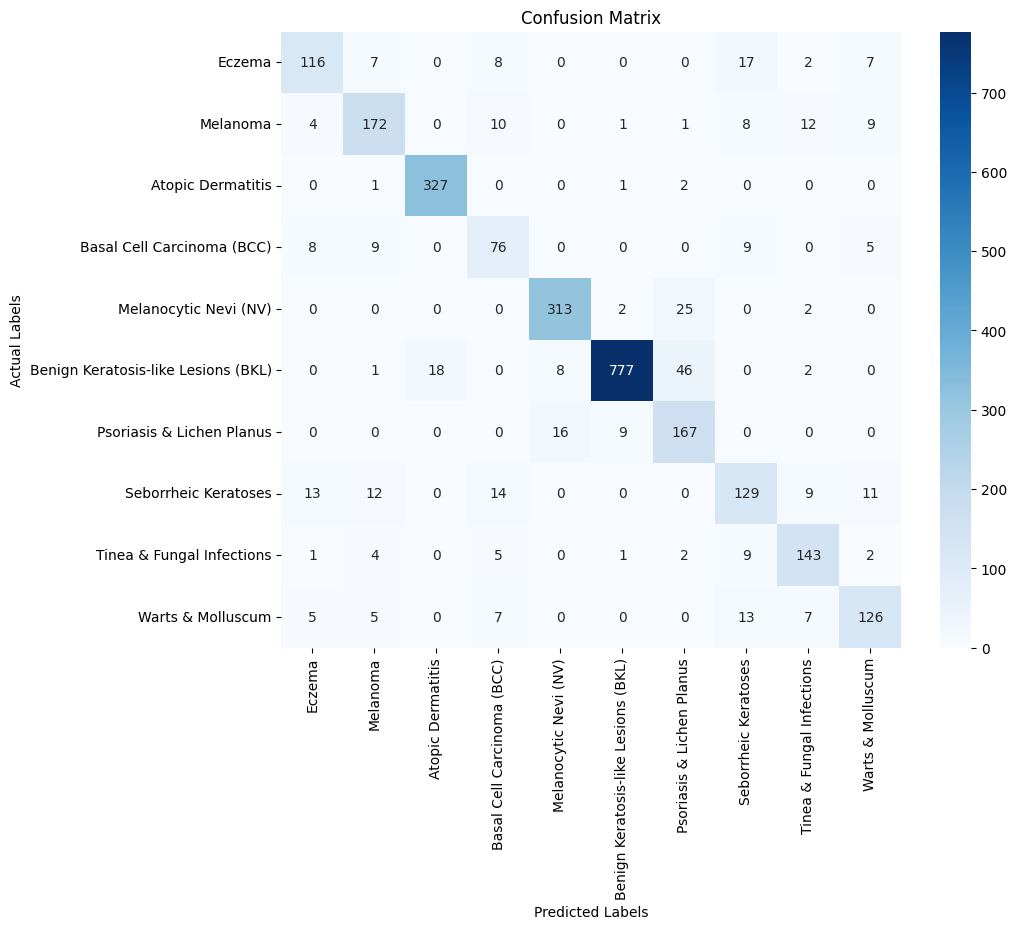

In [62]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())  # Move to CPU for processing
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes, digits=4))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()


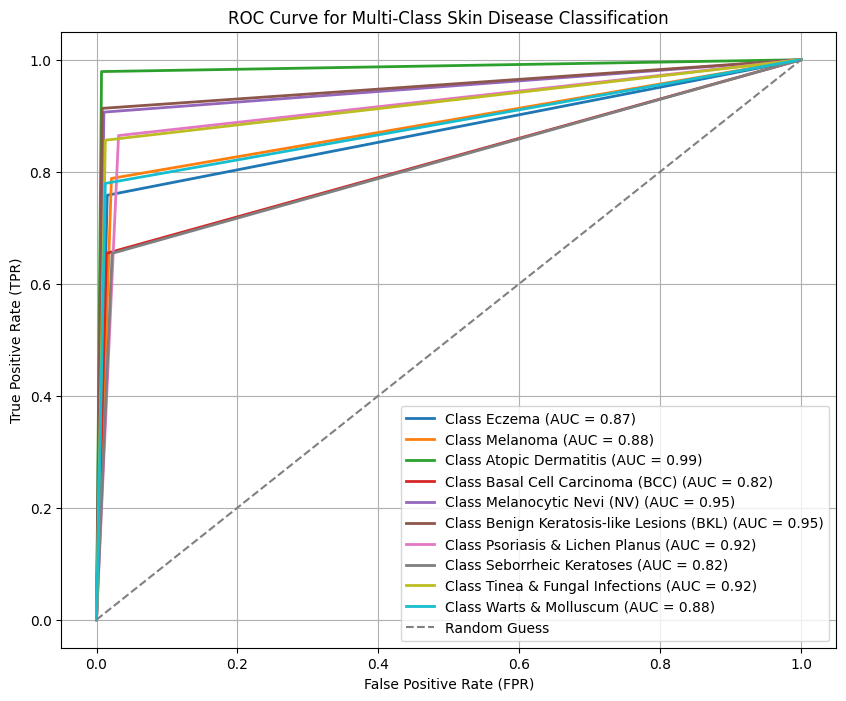

In [57]:
# Convert labels to one-hot encoding
num_classes = len(dataset.classes)
all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], np.array(all_preds) == i)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f"Class {dataset.classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Multi-Class Skin Disease Classification")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [22]:
torch.save(model, "VIT_skin_disease.pth")


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import json

def load_model(model_path, device):
    model = torch.load(model_path, map_location=device)
    model.eval()
    model.to(device)
    return model

# 🔹 Load class names
def load_class_names(class_names_path):
    with open(class_names_path, "r") as f:
        class_names = json.load(f)
    return class_names

# 🔹 Preprocess input image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])
    
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    return image

def predict_disease(image_path, model, class_names, device):
    image = preprocess_image(image_path).to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted_idx = torch.max(output, 1)
    
    predicted_class = class_names[predicted_idx.item()]  
    return predicted_class

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "/kaggle/working/VIT_skin_disease1.pth"  # Your saved model path
class_names_path = "/kaggle/working/class_names.json"

# Load model and class names
class_names = load_class_names(class_names_path)
model = load_model(model_path, device=device)

# Test prediction with an image
image_path = "/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0025777.jpg" 
predicted_disease = predict_disease(image_path, model, class_names, device)

print(f"Predicted Disease: {predicted_disease}")


<ipython-input-26-6116a7648ea1>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


Predicted Disease: Benign Keratosis-like Lesions (BKL)
